# 5) Main Analysis
First, load the data and prepare the session.

In [1]:
# activate virtual environment "masterenv"
import os
#activate_this = os.path.join("home/shared_folder/MA_researcher_wellbeing/masterenv", "bin", "activate_this.py")
#exec(open(activate_this).read(), {'__file__': activate_this})

# import necessary packages
import pandas as pd
import numpy as np
from datetime import datetime
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys
import warnings
warnings.simplefilter("ignore")

# import df for H1
h1_df = pd.read_json("/home/shared_folder/Twitter_samu/MA_researcher_wellbeing/data/h1_df.json", lines=True)
dates = pd.read_csv("/home/shared_folder/Twitter_samu/MA_researcher_wellbeing/data/date.txt", header=None, names=["date_string"])
h1_df["date"] = pd.to_datetime(dates["date_string"], format="%Y-%m-%dT%H:%M:%S.%f")
h1_df.head()

,neg_sent,pos_sent,week(T),pandemic(D),n,date
0,0.168398,0.477529,1,0,19361,2019-03-17
1,0.156548,0.495395,2,0,21597,2019-03-24
2,0.154662,0.513106,3,0,20368,2019-03-31
3,0.152084,0.506698,4,0,22034,2019-04-07
4,0.152721,0.510529,5,0,21875,2019-04-14


### H1: POSITIVE SENTIMENTS

1. Let's try to implement the planned OLS regression model

In [2]:
# define df
Y = h1_df["pos_sent"]
T = h1_df["week(T)"]
D = h1_df["pandemic(D)"]
df = pd.DataFrame({"Y": Y, "T": T, "D": D})

#implement OLS model
model = smf.ols(formula='Y ~ T + D', data=df)
res = model.fit()
print(res.summary(alpha = 0.025))

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     189.0
Date:                Tue, 22 Oct 2024   Prob (F-statistic):           1.56e-34
Time:                        12:47:34   Log-Likelihood:                 275.18
No. Observations:                 102   AIC:                            -544.4
Df Residuals:                      99   BIC:                            -536.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|     [0.0125     0.9875]
------------------------------------------------------------------------------
Intercept      0.5096      0.004    136.464      0.0

The Durbin-Watson is <1.5, indicating a positive autocorrelation.
We can account for this using an ARIMA model.

In [3]:
#%pip install pmdarima
import pmdarima as pm

# fit the ARIMA model automatically 
model = pm.auto_arima(df["Y"], seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-536.901, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-521.913, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-524.270, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-527.412, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-523.632, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-537.942, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-537.628, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-537.506, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-535.657, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-535.551, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-532.786, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-533.271, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-533.728, Time=0.13 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 1.147 seconds


In [4]:
from statsmodels.tsa.arima.model import ARIMA

# specify ARIMA model using the proposed parameters
arima_results = ARIMA(df["Y"], df[["T", "D"]], order=(1,1,2)).fit()
print(arima_results.summary(alpha=0.025))

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  102
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 278.472
Date:                Tue, 22 Oct 2024   AIC                           -544.945
Time:                        12:47:45   BIC                           -529.254
Sample:                             0   HQIC                          -538.593
                                - 102                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|     [0.0125     0.9875]
------------------------------------------------------------------------------
T             -0.0006      0.000     -1.342      0.179      -0.002       0.000
D             -0.0352      0.010     -3.473      0.001      -0.058      -0.012
ar.L1          0.3959      0.370      1.069      0.2

The descriptive statistic says that the official start of the pandemic had a negative effect on the positive sentiments. D (dummy coded variable indicating the start of the pandemic) has a coeficient of -0.035. But some model assumptions are violated (Homoscedasticity (Prob(H)<0.05), normally distributed residuals (Prob(JB)<0.05)). Because of that the inference statistic is not reliable.

Let's use Bootstrapping method to deal our data:

In [6]:
# Define the number of bootstrap samples
n_bootstrap_samples = 1000
coefficient_D_estimates = []

# Set the random seed for reproducibility
np.random.seed(42)

# Define the block size for block bootstrapping
block_size = 3  # how many segments of data are resampled together (I need a quite small block size to capture short-term variation (effect of the start of the pandemic))

# Perform block bootstrapping
for _ in range(n_bootstrap_samples):
    # Generate a bootstrap sample of 'Y' and 'D' using block bootstrapping
    bootstrap_indices = np.random.randint(1, len(df) - block_size, len(df) // block_size)
    bootstrap_indices = np.repeat(bootstrap_indices, block_size) + np.tile(np.arange(block_size), len(bootstrap_indices))
    bootstrap_sample = df.iloc[bootstrap_indices]

    # Fit ARIMA model to the bootstrap sample
    bootstrap_model = ARIMA(bootstrap_sample["Y"], bootstrap_sample[["T", "D"]], order=(1, 1, 2)).fit()

    # Store the estimated coefficient for 'D'
    coefficient_D_estimates.append(bootstrap_model.params["D"])

# Calculate standard errors and confidence intervals for the coefficient of 'D'
coefficient_D_estimates = np.array(coefficient_D_estimates)
coefficient_D_std_error = coefficient_D_estimates.std()
coefficient_D_ci_lower = np.percentile(coefficient_D_estimates, 1.25)
coefficient_D_ci_upper = np.percentile(coefficient_D_estimates, 98.75)

# Print the results
print("Bootstrap Standard Error for Coefficient of 'D':", coefficient_D_std_error)
print("Bootstrap 97.5% Confidence Interval for Coefficient of 'D':")
print("Lower Bound:", coefficient_D_ci_lower)
print("Upper Bound:", coefficient_D_ci_upper)

Bootstrap Standard Error for Coefficient of 'D': 0.009113049958229397
Bootstrap 97.5% Confidence Interval for Coefficient of 'D':
Lower Bound: -0.0521053012055131
Upper Bound: -0.009869885417148403


    Bootstrap Standard Error for Coefficient of 'D': 0.009113049958229397
    Bootstrap 97.5% Confidence Interval for Coefficient of 'D':
    Lower Bound: -0.0521053012055131
    Upper Bound: -0.009869885417148403

Robust estimation of the D coefficient via bootstrapping says that the true value of the D coef lies with 97.5% probability within the range of the **CI [-0.052; -0.010]**. 
**The ARIMA model suggested a value inside of this interval: -0.035.**
The fact that the ARIMA coefficient falls within the bootstrapped confidence interval indicates that the coefficient estimate is consistent with the resampled data. It provides evidence that the coefficient is statistically valid.

Let's plot this:

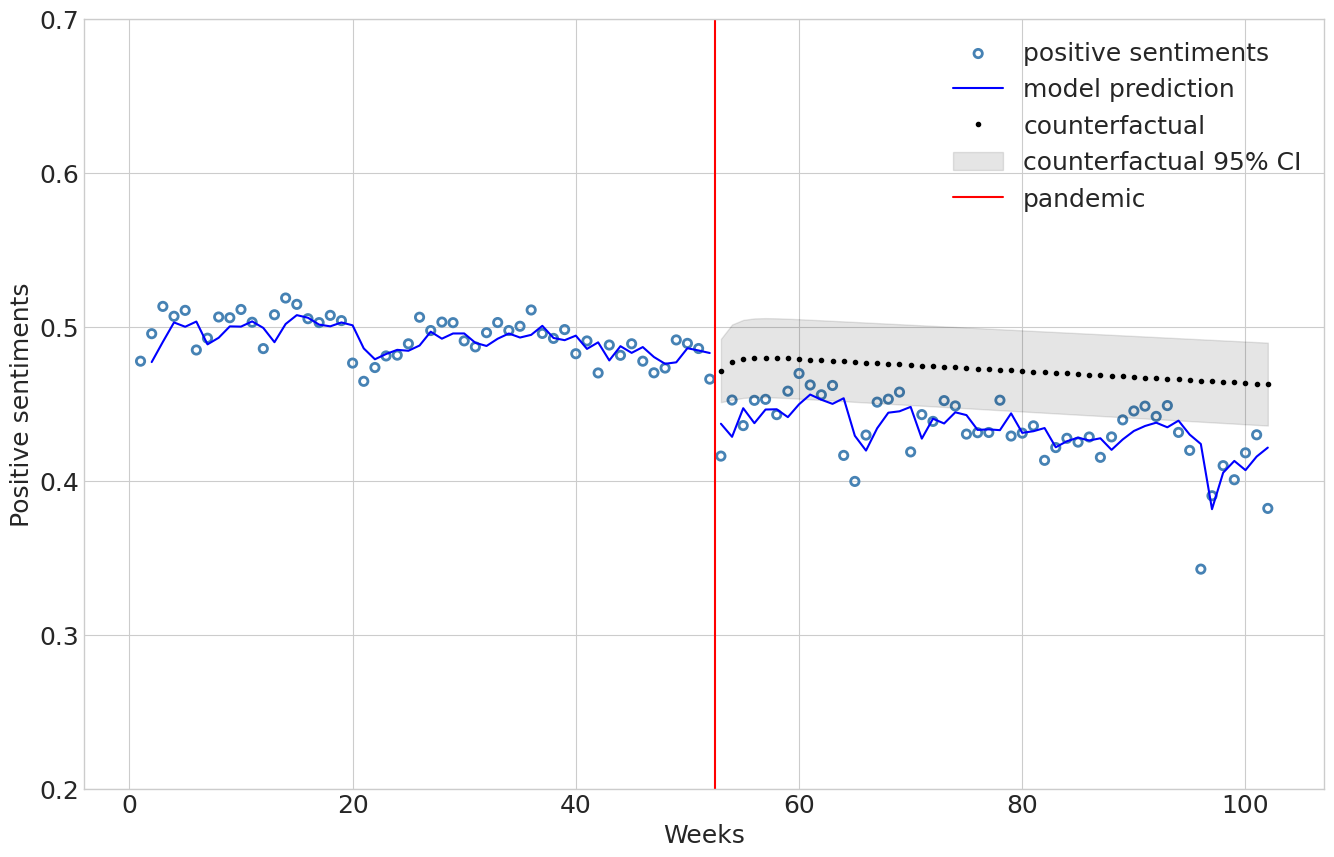

In [8]:
start = 52
end = 102

# get the model predictions for the whole time period (start till end)
predictions = arima_results.get_prediction(0, end-1)
summary = predictions.summary_frame(alpha=0.025)

# get the counterfactual ARIMA by fitting a model only for the first time period (before the pandemic)
arima_cf = ARIMA(df["Y"][:start], df["T"][:start], order=(1,1,2)).fit()

# model predictions means
y_pred = predictions.predicted_mean

# counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(50, exog=df["T"][start:]).summary_frame(alpha=0.05)

# plot section
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# plot weekly sentiment data
ax.scatter(df["T"], df["Y"], facecolors='none', edgecolors='steelblue', label="positive sentiments", linewidths=2)

# plot model mean sentiment prediction
ax.plot(df["T"][1:start], y_pred[1:start], 'b-', label="model prediction")
ax.plot(df["T"][start:], y_pred[start:], 'b-')

# plot counterfactual mean sentiment with 95% confidence interval
ax.plot(df["T"][start:], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(df["T"][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="counterfactual 95% CI")


# plot line marking the week of the official start of the pandemic (WHO)
ax.axvline(x = 52.5, color = 'r', label = 'pandemic')

#ax.legend(loc='best')
#plt.ylim([0.2, 0.7])
#plt.xlabel("Weeks")
#plt.ylabel("Positive sentiments")

# Update font sizes for axis labels and legend
ax.legend(loc='best', fontsize=18)   # Legend font size
ax.set_xlabel("Weeks", fontsize=18)  # X-axis label font size
ax.set_ylabel("Positive sentiments", fontsize=18)  # Y-axis label font size

# Update tick label font size
ax.tick_params(axis='both', which='major', labelsize=18)

plt.ylim([0.2, 0.7])
plt.show()

### H1: NEGATIVE SENTIMENTS

1. Let's also try to implement the planned OLS regression model here

In [9]:
# define df
Y = h1_df["neg_sent"]
T = h1_df["week(T)"]
D = h1_df["pandemic(D)"]
df = pd.DataFrame({"Y": Y, "T": T, "D": D})

#implement OLS model
model = smf.ols(formula='Y ~ T + D', data=df)
res = model.fit()
print(res.summary(alpha = 0.025))

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     202.6
Date:                Tue, 22 Oct 2024   Prob (F-statistic):           1.01e-35
Time:                        12:58:46   Log-Likelihood:                 299.18
No. Observations:                 102   AIC:                            -592.4
Df Residuals:                      99   BIC:                            -584.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|     [0.0125     0.9875]
------------------------------------------------------------------------------
Intercept      0.1470      0.003     49.799      0.0

The Durbin-Watson is <1.5, indicating a positive autocorrelation.
We can account for this using an ARIMA model.

In [10]:
# fit the ARIMA model automatically 
model = pm.auto_arima(df["Y"], seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-570.110, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-581.092, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-582.444, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-584.966, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-582.625, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-593.339, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-598.326, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-583.617, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-594.392, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-598.120, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-583.104, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-591.535, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-591.668, Time=0.07 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.064 seconds


In [11]:
# specify ARIMA model using the proposed parameters
arima_results = ARIMA(df["Y"], df[["T", "D"]], order=(2,1,1)).fit()
print(arima_results.summary(alpha=0.025))

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  102
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 304.441
Date:                Tue, 22 Oct 2024   AIC                           -596.883
Time:                        12:58:52   BIC                           -581.192
Sample:                             0   HQIC                          -590.531
                                - 102                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|     [0.0125     0.9875]
------------------------------------------------------------------------------
T              0.0006      0.000      1.258      0.208      -0.000       0.002
D              0.0172      0.014      1.267      0.205      -0.013       0.048
ar.L1          0.5369      0.129      4.168      0.0

The descriptive statistic says that the official start of the pandemic had a positive effect on the negative sentiments. D (dummy coded variable indicating the start of the pandemic) has a coeficient of 0.172. It is not significant (p>0.05). But some model assumptions are violated (Homoscedasticity (Prob(H)<0.05), normally distributed residuals (Prob(JB)<0.05)). Because of that the inference statistic is not reliable.

Let's use Bootstrapping method to deal with our data:

In [14]:
# Define the number of bootstrap samples
n_bootstrap_samples = 1000
coefficient_D_estimates = []

# Set the random seed for reproducibility
np.random.seed(42)

# Define the block size for block bootstrapping
block_size = 3  # how many segments of data are resampled together (I need a quite small block size to capture short-term variation (effect of the start of the pandemic))

# Perform block bootstrapping
for _ in range(n_bootstrap_samples):
    # Generate a bootstrap sample of 'Y' and 'D' using block bootstrapping
    bootstrap_indices = np.random.randint(1, len(df) - block_size, len(df) // block_size)
    bootstrap_indices = np.repeat(bootstrap_indices, block_size) + np.tile(np.arange(block_size), len(bootstrap_indices))
    bootstrap_sample = df.iloc[bootstrap_indices]

    # Fit ARIMA model to the bootstrap sample
    bootstrap_model = ARIMA(bootstrap_sample["Y"], bootstrap_sample[["T", "D"]], order=(2, 1, 1)).fit()

    # Store the estimated coefficient for 'D'
    coefficient_D_estimates.append(bootstrap_model.params["D"])

# Calculate standard errors and confidence intervals for the coefficient of 'D'
coefficient_D_estimates = np.array(coefficient_D_estimates)
coefficient_D_std_error = coefficient_D_estimates.std()
coefficient_D_ci_lower = np.percentile(coefficient_D_estimates, 1.25)
coefficient_D_ci_upper = np.percentile(coefficient_D_estimates, 98.75)

# Print the results
print("Bootstrap Standard Error for Coefficient of 'D':", coefficient_D_std_error)
print("Bootstrap 97.5% Confidence Interval for Coefficient of 'D':")
print("Lower Bound:", coefficient_D_ci_lower)
print("Upper Bound:", coefficient_D_ci_upper)

Bootstrap Standard Error for Coefficient of 'D': 0.00787483205328958
Bootstrap 97.5% Confidence Interval for Coefficient of 'D':
Lower Bound: -0.003011723880959209
Upper Bound: 0.03215901481052485


    Bootstrap Standard Error for Coefficient of 'D': 0.00787483205328958
    Bootstrap 97.5% Confidence Interval for Coefficient of 'D':
    Lower Bound: -0.003011723880959209
    Upper Bound: 0.03215901481052485

Robust estimation of the D coefficient via bootstrapping says that the true value of the D coef lies with 97.5% probability within the range of the **CI [-0.003; 0.032]**. 
**The ARIMA model suggested a value inside of this interval: 0.017.**
The fact that the ARIMA coefficient falls within the bootstrapped confidence interval indicates that the coefficient estimate is consistent with the resampled data. It provides evidence that the coefficient is statistically valid. The coefficent doesn't get significant in the ARIMA model summary and the bootstrapped 97.5% CI includes D = 0. On a descriptive level we can see a positive effect, but this might not be generalizable. 

Let's plot this:

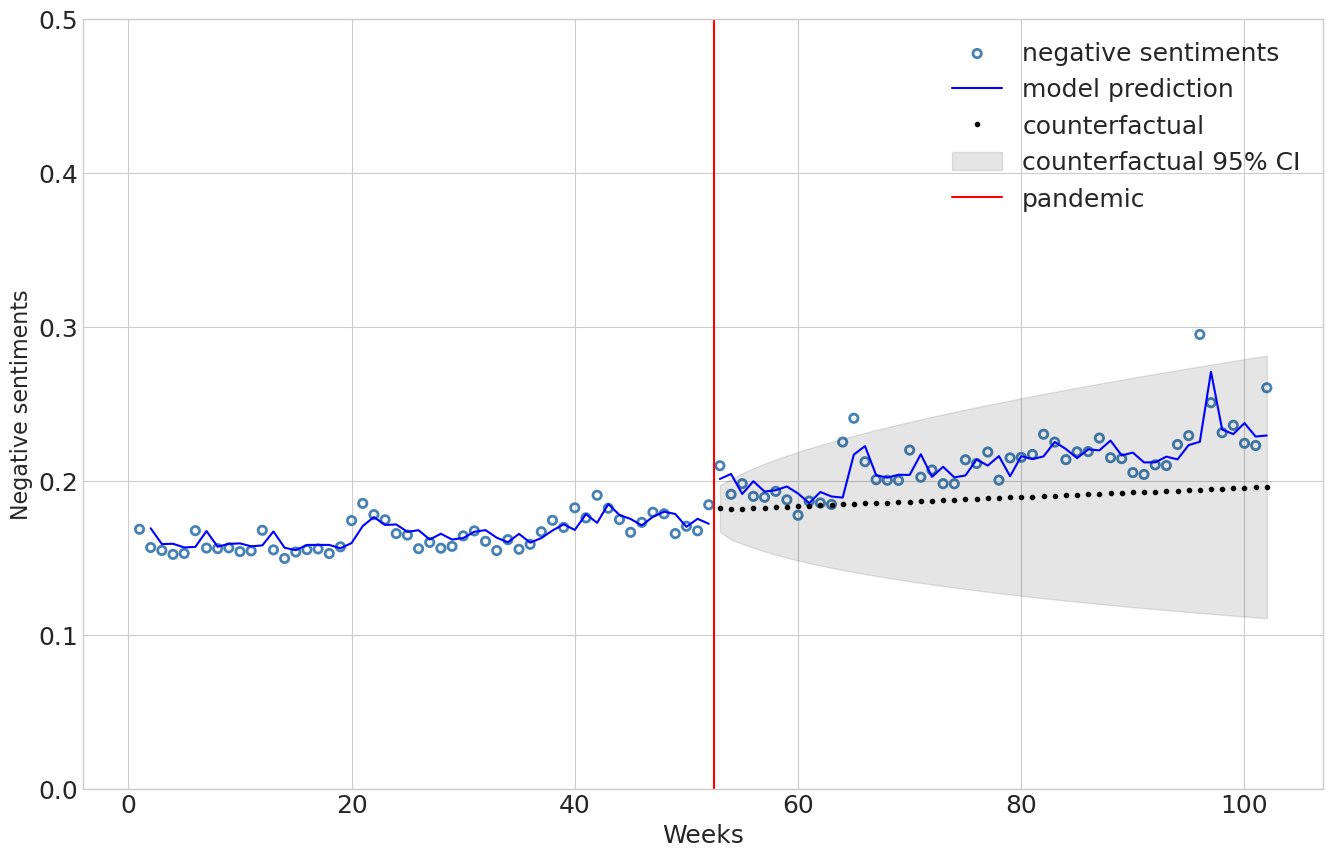

In [15]:
start = 52
end = 102

# get the model predictions for the whole time period (start till end)
predictions = arima_results.get_prediction(0, end-1)
summary = predictions.summary_frame(alpha=0.025)

# get the counterfactual ARIMA by fitting a model only for the first time period (before the pandemic)
arima_cf = ARIMA(df["Y"][:start], df["T"][:start], order=(2,1,1)).fit()

# model predictions means
y_pred = predictions.predicted_mean

# counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(50, exog=df["T"][start:]).summary_frame(alpha=0.05)

# plot section
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# plot weekly sentiment data
ax.scatter(df["T"], df["Y"], facecolors='none', edgecolors='steelblue', label="negative sentiments", linewidths=2)

# plot model mean sentiment prediction
ax.plot(df["T"][1:start], y_pred[1:start], 'b-', label="model prediction")
ax.plot(df["T"][start:], y_pred[start:], 'b-')

# plot counterfactual mean sentiment with 95% confidence interval
ax.plot(df["T"][start:], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(df["T"][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="counterfactual 95% CI")


# plot line marking the week of the official start of the pandemic (WHO)
ax.axvline(x = 52.5, color = 'r', label = 'pandemic')

#ax.legend(loc='best')
#plt.ylim([0, 0.5])
#plt.xlabel("Weeks")
#plt.ylabel("Negative sentiments")

# Update font sizes for axis labels and legend
ax.legend(loc='best', fontsize=18)   # Legend font size
ax.set_xlabel("Weeks", fontsize=18)  # X-axis label font size
ax.set_ylabel("Negative sentiments", fontsize=16)  # Y-axis label font size

# Update tick label font size
ax.tick_params(axis='both', which='major', labelsize=18)

plt.ylim([0, 0.5])
plt.show()

We can see that the plotted weekly negative sentiments mostly lay above the counterprediction, so on a descriptive level you can see the positive effect of the start of the pandemic on the negative sentiments, but the actual data lay within the CI of the counterfactual which goes along with the not significant p-value.

In [16]:
from scipy import stats

correlation_coefficient, p_value = stats.pearsonr(h1_df["pos_sent"], h1_df["neg_sent"])
print(correlation_coefficient)

-0.9832700244822045


-0.98 is an almost perfect negative correlation -> There is a need to adjust the alpha to 0.025 (as we did)

### H2: POSITIVE SENTIMENTS

In [17]:
# first load the df
# gender: male = 0, female = 1
h2_df = pd.read_json("/home/shared_folder/Twitter_samu/MA_researcher_wellbeing/data/h2_df.json", lines=True)
h2_df.head()

,neg_sent,pos_sent,n,gender,week_T,pandemic_D
0,0.189168,0.400003,7260,0,1,0
1,0.179083,0.423674,7466,0,2,0
2,0.170801,0.438895,7011,0,3,0
3,0.180076,0.409947,7653,0,4,0
4,0.178528,0.424919,7672,0,5,0


In [18]:
# defining model
model_formula = "pos_sent ~ pandemic_D + week_T + gender + pandemic_D * gender"

# Create a mixed-effects model with random intercepts for 'gender'
model = smf.mixedlm(model_formula, h2_df, groups=h2_df["gender"])
result = model.fit()

print(result.summary(alpha=0.025))

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    pos_sent
No. Observations:     204        Method:                REML    
No. Groups:           2          Scale:                 0.0003  
Min. group size:      102        Log-Likelihood:        509.8147
Max. group size:      102        Converged:             Yes     
Mean group size:      102.0                                     
----------------------------------------------------------------
                  Coef.   Std.Err.    z    P>|z| [0.0125 0.9875]
----------------------------------------------------------------
Intercept          0.430      0.018 24.205 0.000   0.390   0.470
pandemic_D        -0.023      0.005 -4.226 0.000  -0.035  -0.011
week_T            -0.001      0.000 -6.397 0.000  -0.001  -0.000
gender             0.149      0.025  5.962 0.000   0.093   0.205
pandemic_D:gender -0.013      0.005 -2.717 0.007  -0.024  -0.002
Group Var          0.000 297804.580    

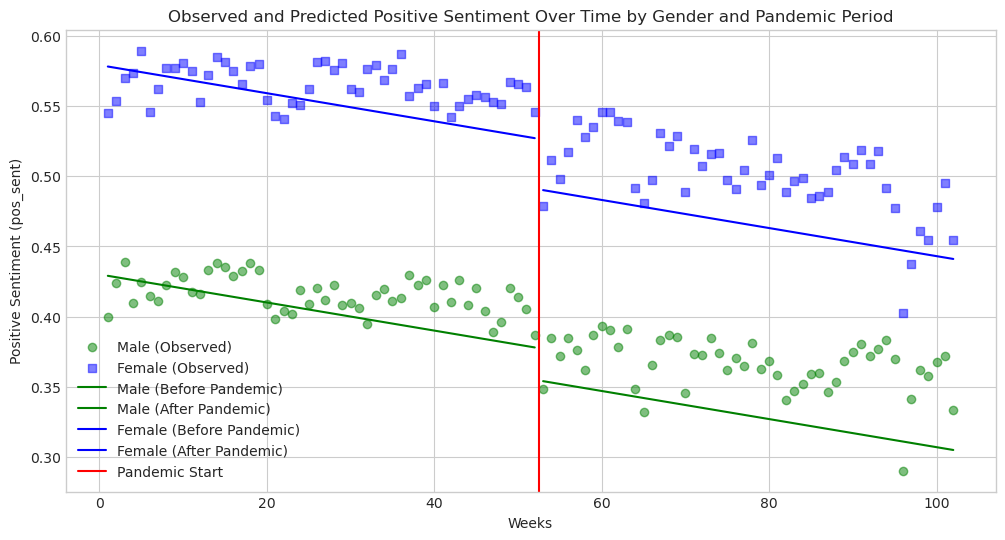

In [19]:
import matplotlib.pyplot as plt
import numpy as np


intercept = 0.43
pandemic_coeff = -0.023
week_coeff = -0.001
gender_coeff = 0.149
pandemic_gender_interaction_coeff = -0.013


# Create a range of values for the predictor variable 'week_T'
weeks = np.arange(1, 103)  # Weeks from 1 to 102

# Create a mask to identify weeks before and after the pandemic
before_pandemic_mask = weeks <= 52
after_pandemic_mask = weeks > 52

# Calculate model predictions for both male and female groups
predicted_pos_sent_male_before = (
    intercept +
    pandemic_coeff * 0 +  # Assuming baseline scenario for pandemic_D
    week_coeff * weeks[before_pandemic_mask] +
    gender_coeff * 0 +  # Male group
    pandemic_gender_interaction_coeff * 0  # No interaction effect for baseline
)

predicted_pos_sent_male_after = (
    intercept +
    pandemic_coeff * 1 +  # Assuming pandemic scenario for pandemic_D
    week_coeff * weeks[after_pandemic_mask] +
    gender_coeff * 0 +  # Male group
    pandemic_gender_interaction_coeff * 0
)

predicted_pos_sent_female_before = (
    intercept +
    pandemic_coeff * 0 +  # Assuming baseline scenario for pandemic_D
    week_coeff * weeks[before_pandemic_mask] +
    gender_coeff * 1 +  # Female group
    pandemic_gender_interaction_coeff * 0  # No interaction effect for baseline
)

predicted_pos_sent_female_after = (
    intercept +
    pandemic_coeff * 1 +  # Assuming pandemic scenario for pandemic_D
    week_coeff * weeks[after_pandemic_mask] +
    gender_coeff * 1 +  # Female group
    pandemic_gender_interaction_coeff * 1  # Interaction effect for pandemic
)

# Separate data for male (gender = 0) and female (gender = 1) groups
male_data = h2_df[h2_df['gender'] == 0]
female_data = h2_df[h2_df['gender'] == 1]

# Extract relevant columns for plotting
pos_sent_male = male_data['pos_sent']
pos_sent_female = female_data['pos_sent']

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot observed positive sentiment for the male group
plt.scatter(weeks, pos_sent_male, label='Male (Observed)', marker='o', alpha = 0.5, color = "green")

# Plot observed positive sentiment for the female group
plt.scatter(weeks, pos_sent_female, label='Female (Observed)', marker='s', alpha = 0.5, color = "blue")

# Overlay model predictions for male group before and after the pandemic
plt.plot(weeks[before_pandemic_mask], predicted_pos_sent_male_before, label='Male (Before Pandemic)', color = "green")
plt.plot(weeks[after_pandemic_mask], predicted_pos_sent_male_after, label='Male (After Pandemic)', color = "green")

# Overlay model predictions for female group before and after the pandemic
plt.plot(weeks[before_pandemic_mask], predicted_pos_sent_female_before, label='Female (Before Pandemic)', color = "blue")
plt.plot(weeks[after_pandemic_mask], predicted_pos_sent_female_after, label='Female (After Pandemic)', color = "blue")

# Add a vertical red line to indicate the start of the pandemic
plt.axvline(x=52.5, color='red', label='Pandemic Start')

# Add labels and title
plt.xlabel('Weeks')
plt.ylabel('Positive Sentiment (pos_sent)')
plt.title('Observed and Predicted Positive Sentiment Over Time by Gender and Pandemic Period')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Let's have a look at the model assumptions!

1. assumption: linearity
- test: plot the residuals

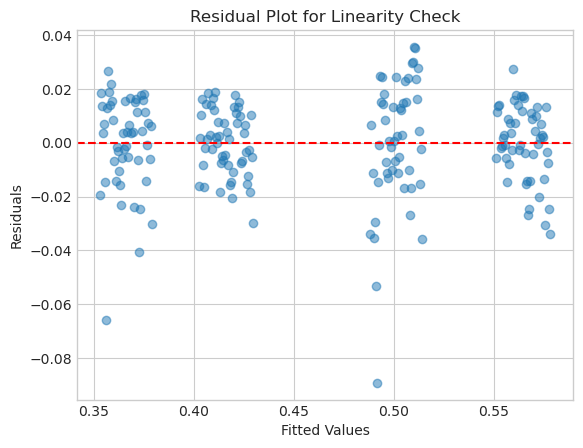

In [20]:
# Obtain the residuals from the fitted mixed-effects model
residuals = result.resid

# Create a scatterplot of residuals vs. the fitted values
plt.scatter(result.fittedvalues, residuals, alpha=0.5)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Linearity Check")
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.show()

We can see clustering and extreme outliers (especially in the third cluster).
It suggests that there may be issues with the model's fit and the linearity assumption.
Transforming the data could be a possible solution. 
But first, inspect the data further with respect to the model assumptions.

2. assumption: normality of residuals
- test:  Shapiro-Wilk test

In [21]:
from scipy import stats

shapiro_test_statistic, shapiro_p_value = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test - Test Statistic: {shapiro_test_statistic}, p-value: {shapiro_p_value}")

Shapiro-Wilk Test - Test Statistic: 0.938983142375946, p-value: 1.4763489275537722e-07


The p-value is <0.5, indicating non-normality of residuals.
Transforming my data could be a possible fix. 
But first, I want to continue "diagnosing" my data:

3. assumption: homoscedasticity

In [22]:
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan

# Extract the exogenous variables used in your model
exog_vars = model.exog

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(residuals, exog_vars)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

# Print the test results
print(lzip(labels, bp_test))

[('LM Statistic', 12.431409354750182), ('LM-Test p-value', 0.014415592848599893), ('F-Statistic', 3.228413453978488), ('F-Test p-value', 0.013554324715605687)]


In summary, both the LM-Test p-value and the F-Test p-value are less than 0.05, indicating that there is statistically significant evidence of heteroscedasticity in the data.

Ok let's stop there for now and see how we can adress these issues. 
We can try to transform the data.

In [23]:
# transform with box-cox transformation
from scipy.stats import boxcox
h2_pos_boxcox, lambda_best_fit = boxcox(h2_df["pos_sent"])

h2_df["pos_boxcox"] = h2_pos_boxcox

In [24]:
# defining model with transformed data
model_formula = "pos_boxcox ~ pandemic_D + week_T + gender + pandemic_D * gender"

# Create a mixed-effects model with random intercepts for 'gender'
model = smf.mixedlm(model_formula, h2_df, groups=h2_df["gender"])
result = model.fit()

print(result.summary(alpha=0.025))

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    pos_boxcox
No. Observations:    204        Method:                REML      
No. Groups:          2          Scale:                 0.0009    
Min. group size:     102        Log-Likelihood:        406.9005  
Max. group size:     102        Converged:             Yes       
Mean group size:     102.0                                       
-----------------------------------------------------------------
                  Coef.   Std.Err.     z    P>|z| [0.0125 0.9875]
-----------------------------------------------------------------
Intercept         -0.726      0.030 -24.345 0.000  -0.793  -0.659
pandemic_D        -0.046      0.009  -5.056 0.000  -0.067  -0.026
week_T            -0.001      0.000  -6.312 0.000  -0.001  -0.001
gender             0.234      0.042   5.594 0.000   0.140   0.328
pandemic_D:gender -0.004      0.008  -0.473 0.636  -0.022   0.015
Group Var          0.001

First look at the linearity again:

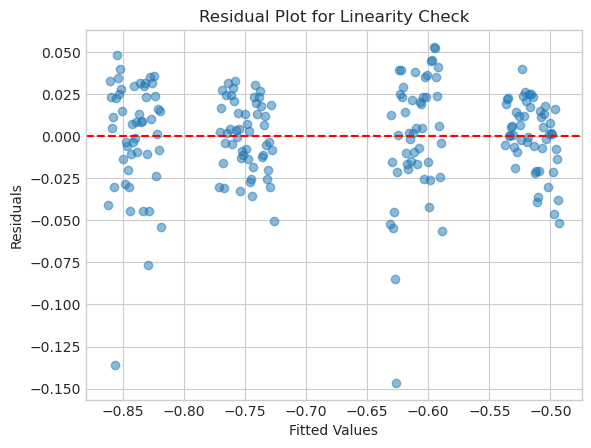

In [25]:
# Obtain the residuals from the fitted mixed-effects model
residuals = result.resid

# Create a scatterplot of residuals vs. the fitted values
plt.scatter(result.fittedvalues, residuals, alpha=0.5)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Linearity Check")
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.show()

In [26]:
# shapiro test to check the normality of the residuals
shapiro_test_statistic, shapiro_p_value = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test - Test Statistic: {shapiro_test_statistic}, p-value: {shapiro_p_value}")

Shapiro-Wilk Test - Test Statistic: 0.919349193572998, p-value: 3.9878407243065794e-09


still significant

In [27]:
# Extract the exogenous variables used in your model
exog_vars = model.exog

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(residuals, exog_vars)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

# Print the test results
print(lzip(labels, bp_test))

[('LM Statistic', 10.25498968083189), ('LM-Test p-value', 0.036344628919880065), ('F-Statistic', 2.6332845206228823), ('F-Test p-value', 0.03544204472833727)]


also still significant...

Let's try something else and do this analysis analogous to the one in H1 with fitting an ARIMA model (fitted better anyways), bootstrapping for the pandemic coeff and then comparing the coeffs from the male and female subgroup using Wald test.

### H2: POSITIVE - ARIMA female

In [28]:
# load female df
h2_df_female = pd.read_json("/home/shared_folder/Twitter_samu/MA_researcher_wellbeing/data/h2_df_female.json", lines=True)
h2_df_female.head()

,neg_sent,pos_sent,n,gender,week_T,pandemic_D
0,0.147621,0.544616,7886,1,1,0
1,0.135992,0.553225,9448,1,2,0
2,0.138138,0.569741,8737,1,3,0
3,0.128806,0.573372,9519,1,4,0
4,0.125311,0.589343,8993,1,5,0


In [29]:
# define df
Y = h2_df_female["pos_sent"]
T = h2_df_female["week_T"]
D = h2_df_female["pandemic_D"]
df_f = pd.DataFrame({"Y": Y, "T": T, "D": D})

In [30]:
# fit the ARIMA model automatically 
model = pm.auto_arima(df_f["Y"], seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-506.750, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-508.923, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-510.473, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-508.535, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-521.823, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-517.050, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-517.196, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-508.410, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-518.489, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.675 seconds


In [31]:
# specify ARIMA model using the proposed parameters
arima_results_f = ARIMA(df_f["Y"], df_f[["T", "D"]], order=(1,1,1)).fit()
print(arima_results_f.summary(alpha=0.025))

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  102
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 270.451
Date:                Tue, 22 Oct 2024   AIC                           -530.901
Time:                        13:16:52   BIC                           -517.826
Sample:                             0   HQIC                          -525.608
                                - 102                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|     [0.0125     0.9875]
------------------------------------------------------------------------------
T             -0.0005      0.000     -1.571      0.116      -0.001       0.000
D             -0.0426      0.010     -4.123      0.000      -0.066      -0.019
ar.L1          0.5723      0.115      4.985      0.0

The descriptive statistic says that the official start of the pandemic had a negative effect on the positive sentiments. D (dummy coded variable indicating the start of the pandemic) has a **coeficient of -0.0426**. But some model assumptions are violated (Homoscedasticity (Prob(H)<0.05), normally distributed residuals (Prob(JB)<0.05)). Because of that the inference statistic is not reliable.

Let's use Bootstrapping method to deal our data:

In [33]:
# Define the number of bootstrap samples
n_bootstrap_samples = 1000
coefficient_D_estimates = []

# Set the random seed for reproducibility
np.random.seed(42)

# Define the block size for block bootstrapping
block_size = 3  # how many segments of data are resampled together (I need a quite small block size to capture short-term variation (effect of the start of the pandemic))

# Perform block bootstrapping
for _ in range(n_bootstrap_samples):
    # Generate a bootstrap sample of 'Y' and 'D' using block bootstrapping
    bootstrap_indices = np.random.randint(1, len(df_f) - block_size, len(df_f) // block_size)
    bootstrap_indices = np.repeat(bootstrap_indices, block_size) + np.tile(np.arange(block_size), len(bootstrap_indices))
    bootstrap_sample = df_f.iloc[bootstrap_indices]

    # Fit ARIMA model to the bootstrap sample
    bootstrap_model = ARIMA(bootstrap_sample["Y"], bootstrap_sample[["T", "D"]], order=(1, 1, 1)).fit()

    # Store the estimated coefficient for 'D'
    coefficient_D_estimates.append(bootstrap_model.params["D"])

# Calculate standard errors and confidence intervals for the coefficient of 'D'
coefficient_D_estimates = np.array(coefficient_D_estimates)
coefficient_D_std_error = coefficient_D_estimates.std()
coefficient_D_ci_lower = np.percentile(coefficient_D_estimates, 1.25)
coefficient_D_ci_upper = np.percentile(coefficient_D_estimates, 98.75)

# Print the results
print("Bootstrap Standard Error for Coefficient of 'D':", coefficient_D_std_error)
print("Bootstrap 97.5% Confidence Interval for Coefficient of 'D':")
print("Lower Bound:", coefficient_D_ci_lower)
print("Upper Bound:", coefficient_D_ci_upper)

Bootstrap Standard Error for Coefficient of 'D': 0.012903917054404803
Bootstrap 97.5% Confidence Interval for Coefficient of 'D':
Lower Bound: -0.057653430198765655
Upper Bound: -0.0005778800454186645


    Bootstrap Standard Error for Coefficient of 'D': 0.012903917054404803
    Bootstrap 97.5% Confidence Interval for Coefficient of 'D':
    Lower Bound: -0.057653430198765655
    Upper Bound: -0.0005778800454186645

Robust estimation of the D coefficient via bootstrapping says that the true value of the D coef lies with 97.5% probability within the range of the **CI [-0.058; -0.001]**. 
**The ARIMA model suggested a value inside of this interval: -0.0426.**
The fact that the ARIMA coefficient falls within the bootstrapped confidence interval underscores the roustness of the estimated coef, indicating that it remains stable under different resampling scenarios. However, the CI is quite wide (and the SE quite high), suggesting that there is a fair amount of uncertainty in the coef estimate. The CI also includes zero, meaning that there is a possibility that the coef doesn't have a meaningful effect (not statistically significantly different from zero/no strong evidence for a significant effect). It is also possible that the interval is wide simply due to sample variation. 
To interpret the results, we should focus on the point estimate of the coef within the CI because it represents the best estimate of the effect's magnitude. 

Let's plot this:

Text(0, 0.5, 'Positive sentiments')

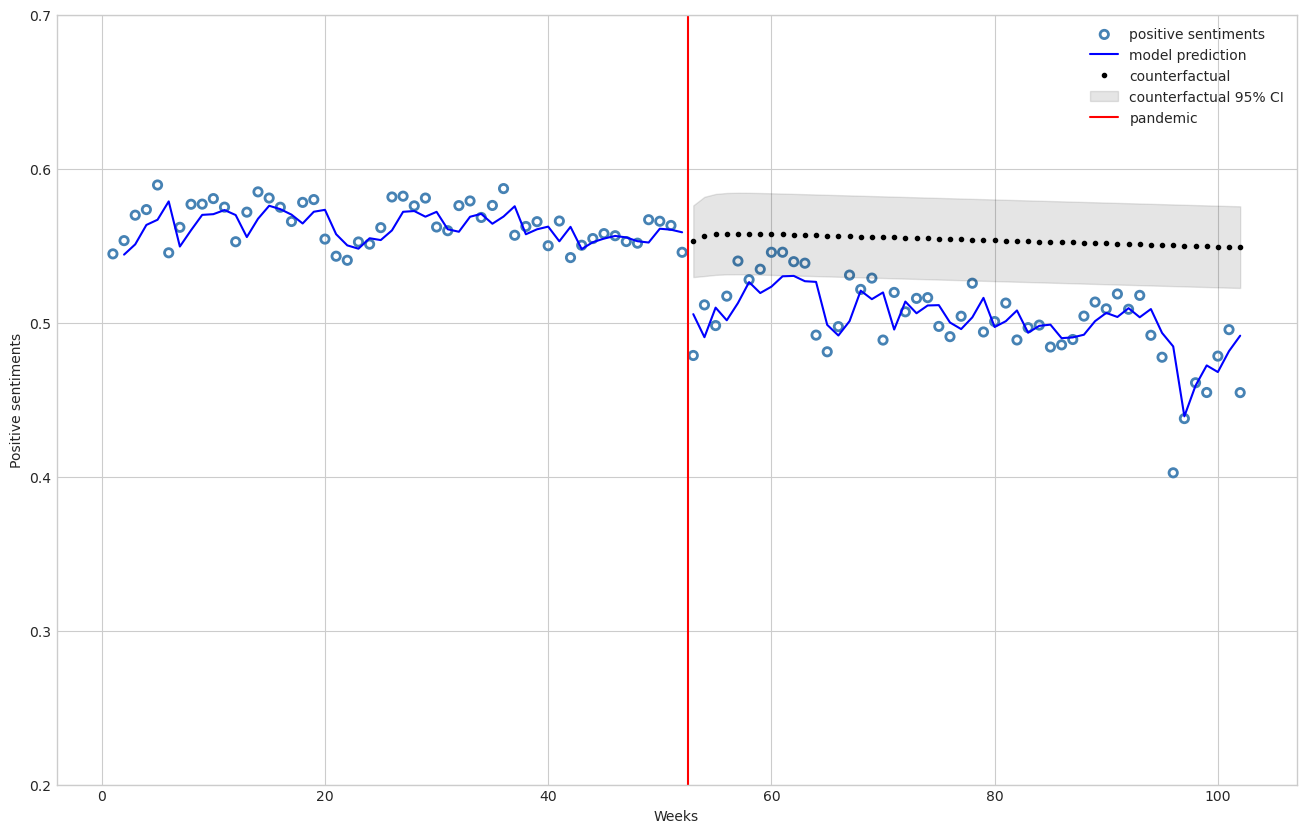

In [34]:
start = 52
end = 102

# get the model predictions for the whole time period (start till end)
predictions = arima_results_f.get_prediction(0, end-1)
summary = predictions.summary_frame(alpha=0.025)

# get the counterfactual ARIMA by fitting a model only for the first time period (before the pandemic)
arima_cf = ARIMA(df_f["Y"][:start], df_f["T"][:start], order=(1,1,1)).fit()

# model predictions means
y_pred = predictions.predicted_mean

# counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(50, exog=df_f["T"][start:]).summary_frame(alpha=0.05)

# plot section
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# plot weekly sentiment data
ax.scatter(df_f["T"], df_f["Y"], facecolors='none', edgecolors='steelblue', label="positive sentiments", linewidths=2)

# plot model mean sentiment prediction
ax.plot(df_f["T"][1:start], y_pred[1:start], 'b-', label="model prediction")
ax.plot(df_f["T"][start:], y_pred[start:], 'b-')

# plot counterfactual mean sentiment with 95% confidence interval
ax.plot(df_f["T"][start:], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(df_f["T"][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="counterfactual 95% CI")


# plot line marking the week of the official start of the pandemic (WHO)
ax.axvline(x = 52.5, color = 'r', label = 'pandemic')

ax.legend(loc='best')
plt.ylim([0.2, 0.7])
plt.xlabel("Weeks")
plt.ylabel("Positive sentiments")

### H2: POSITIVE - ARIMA male

In [35]:
# load male df
h2_df_male = pd.read_json("/home/shared_folder/Twitter_samu/MA_researcher_wellbeing/data/h2_df_male.json", lines=True)
h2_df_male.head()

,neg_sent,pos_sent,n,gender,week_T,pandemic_D
0,0.189168,0.400003,7260,0,1,0
1,0.179083,0.423674,7466,0,2,0
2,0.170801,0.438895,7011,0,3,0
3,0.180076,0.409947,7653,0,4,0
4,0.178528,0.424919,7672,0,5,0


In [36]:
# define df
Y = h2_df_male["pos_sent"]
T = h2_df_male["week_T"]
D = h2_df_male["pandemic_D"]
df_m = pd.DataFrame({"Y": Y, "T": T, "D": D})

In [37]:
# fit the ARIMA model automatically 
model = pm.auto_arima(df_m["Y"], seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-543.705, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-522.949, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-526.742, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-537.861, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-524.810, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-545.169, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-546.894, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-545.722, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-547.279, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-545.283, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-529.994, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-543.771, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.954 seconds


In [38]:
# specify ARIMA model using the proposed parameters
arima_results_m = ARIMA(df_m["Y"], df_m[["T", "D"]], order=(1,1,1)).fit()
print(arima_results_m.summary(alpha=0.025))

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  102
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 284.250
Date:                Tue, 22 Oct 2024   AIC                           -558.501
Time:                        13:33:21   BIC                           -545.425
Sample:                             0   HQIC                          -553.208
                                - 102                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|     [0.0125     0.9875]
------------------------------------------------------------------------------
T             -0.0004      0.000     -2.530      0.011      -0.001   -4.73e-05
D             -0.0293      0.008     -3.785      0.000      -0.047      -0.012
ar.L1          0.3093      0.133      2.321      0.0

The descriptive statistic says that the official start of the pandemic had a negative effect on the positive sentiments. D (dummy coded variable indicating the start of the pandemic) has a **coeficient of -0.0293**. But some model assumptions are violated (Homoscedasticity (Prob(H)<0.05), normally distributed residuals (Prob(JB)<0.05)). Because of that the inference statistic is not reliable.

Let's use Bootstrapping method to deal our data:

In [39]:
# Define the number of bootstrap samples
n_bootstrap_samples = 1000
coefficient_D_estimates = []

# Set the random seed for reproducibility
np.random.seed(42)

# Define the block size for block bootstrapping
block_size = 3  # how many segments of data are resampled together (I need a quite small block size to capture short-term variation (effect of the start of the pandemic))

# Perform block bootstrapping
for _ in range(n_bootstrap_samples):
    # Generate a bootstrap sample of 'Y' and 'D' using block bootstrapping
    bootstrap_indices = np.random.randint(1, len(df_m) - block_size, len(df_m) // block_size)
    bootstrap_indices = np.repeat(bootstrap_indices, block_size) + np.tile(np.arange(block_size), len(bootstrap_indices))
    bootstrap_sample = df_m.iloc[bootstrap_indices]

    # Fit ARIMA model to the bootstrap sample
    bootstrap_model = ARIMA(bootstrap_sample["Y"], bootstrap_sample[["T", "D"]], order=(1, 1, 1)).fit()

    # Store the estimated coefficient for 'D'
    coefficient_D_estimates.append(bootstrap_model.params["D"])

# Calculate standard errors and confidence intervals for the coefficient of 'D'
coefficient_D_estimates = np.array(coefficient_D_estimates)
coefficient_D_std_error = coefficient_D_estimates.std()
coefficient_D_ci_lower = np.percentile(coefficient_D_estimates, 1.25)
coefficient_D_ci_upper = np.percentile(coefficient_D_estimates, 98.75)

# Print the results
print("Bootstrap Standard Error for Coefficient of 'D':", coefficient_D_std_error)
print("Bootstrap 97.5% Confidence Interval for Coefficient of 'D':")
print("Lower Bound:", coefficient_D_ci_lower)
print("Upper Bound:", coefficient_D_ci_upper)

Bootstrap Standard Error for Coefficient of 'D': 0.0075465299265594
Bootstrap 97.5% Confidence Interval for Coefficient of 'D':
Lower Bound: -0.045874021458431335
Upper Bound: -0.011751587647478495


    Bootstrap Standard Error for Coefficient of 'D': 0.0075465299265594
    Bootstrap 97.5% Confidence Interval for Coefficient of 'D':
    Lower Bound: -0.045874021458431335
    Upper Bound: -0.011751587647478495

Robust estimation of the D coefficient via bootstrapping says that the true value of the D coef lies with 97.5% probability within the range of the **CI [-0.046; -0.012]**. 
**The ARIMA model suggested a value inside of this interval: -0.0293.**
The fact that the ARIMA coefficient falls within the bootstrapped confidence interval underscores the roustness of the estimated coef, indicating that it remains stable under different resampling scenarios. This result suggests that the coef's significance is not solely dependent on the specific dataset but holds potential generalizability to a broader population. The consistency of the coefficient estimate with the bootstrapped data provides increased confidence in its validity, reinforcing its potential as a reliable predictor in the ARIMA model. By accounting for sampling variability through bootstrapping, the inference regarding the coef is more reliable and less susceptible to outliers or unusual data points.
To interpret the results, we should focus on the point estimate of the coef within the CI because it represents the best estimate of the effect's magnitude. 

Let's plot this:

Text(0, 0.5, 'Positive sentiments')

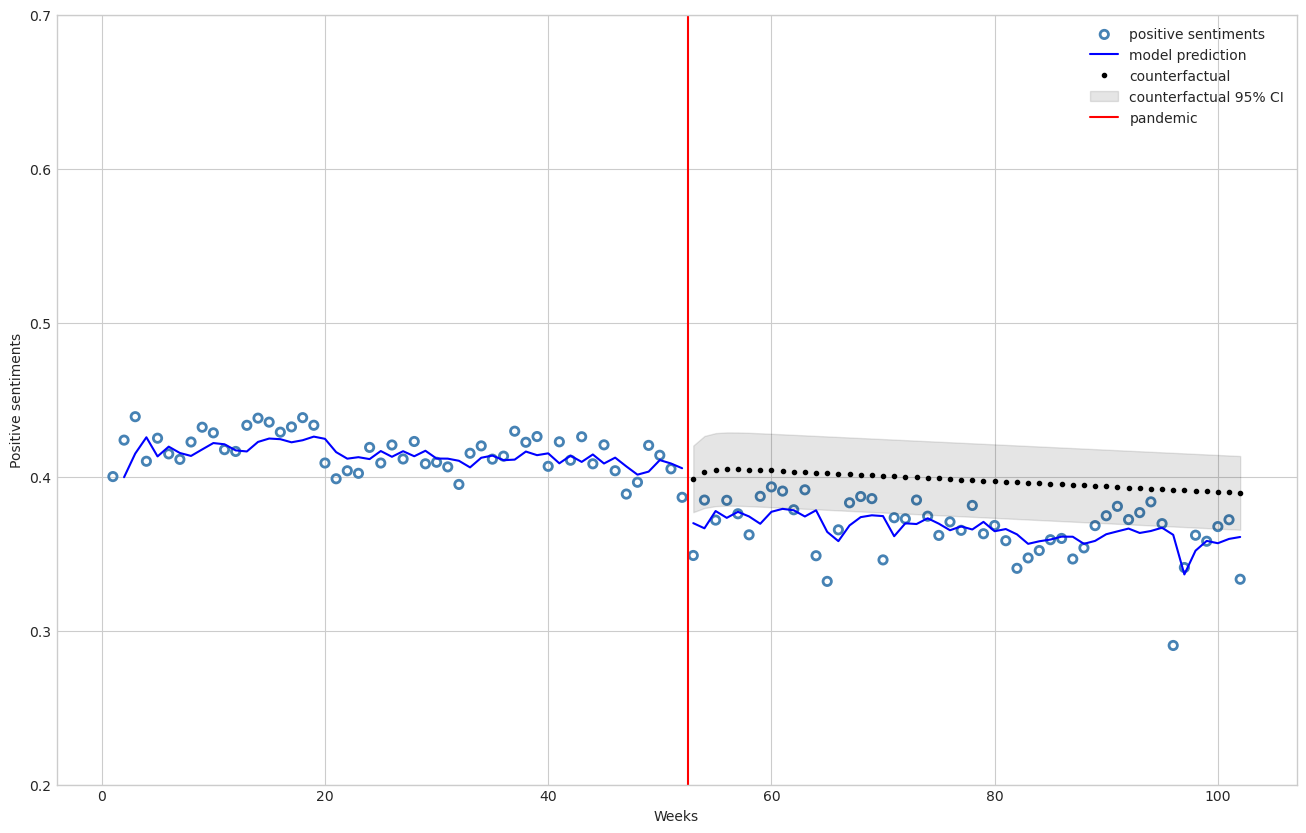

In [40]:
start = 52
end = 102

# get the model predictions for the whole time period (start till end)
predictions = arima_results_m.get_prediction(0, end-1)
summary = predictions.summary_frame(alpha=0.025)

# get the counterfactual ARIMA by fitting a model only for the first time period (before the pandemic)
arima_cf = ARIMA(df_m["Y"][:start], df_m["T"][:start], order=(1,1,1)).fit()

# model predictions means
y_pred = predictions.predicted_mean

# counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(50, exog=df_m["T"][start:]).summary_frame(alpha=0.05)

# plot section
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# plot weekly sentiment data
ax.scatter(df_m["T"], df_m["Y"], facecolors='none', edgecolors='steelblue', label="positive sentiments", linewidths=2)

# plot model mean sentiment prediction
ax.plot(df_m["T"][1:start], y_pred[1:start], 'b-', label="model prediction")
ax.plot(df_m["T"][start:], y_pred[start:], 'b-')

# plot counterfactual mean sentiment with 95% confidence interval
ax.plot(df_m["T"][start:], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(df_m["T"][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="counterfactual 95% CI")


# plot line marking the week of the official start of the pandemic (WHO)
ax.axvline(x = 52.5, color = 'r', label = 'pandemic')

ax.legend(loc='best')
plt.ylim([0.2, 0.7])
plt.xlabel("Weeks")
plt.ylabel("Positive sentiments")

### H2: POSITIVE - coeff comparison

We are interested in whether the pandemic had a stronger effect on females than on males.
To answer this question, let's ckeck whether the pandemic coefficents (D) differ significantly between females and males using the Wald test.

In [41]:
# coefficient estimates (ARIMA) and standard errors (estimated via bootstrapping) from the two models
beta_f = -0.0426
se_f = 0.0129
beta_m = -0.0293
se_m = 0.0076

# calculate the Wald test statistic
wald_statistic = ((beta_f - beta_m) ** 2) / (se_f ** 2 + se_m ** 2)

# calculate the p-value
p_val = 1 - stats.chi2.cdf(wald_statistic, df=1) # 1 degree of freedom

# print the results
print(f"Wald Test Statistic: {wald_statistic}")
print(f"P-value: {p_val}")

# check if the coefficients are significantly different
if p_val < 0.05:
    print("Reject the null hypothesis: Coefficients are significantly different.")
else:
    print("Fail to reject the null hypothesis: Coefficients are not significantly different.")

Wald Test Statistic: 0.789088638087166
P-value: 0.3743758436416784
Fail to reject the null hypothesis: Coefficients are not significantly different.


The pandemic's effect on the positive sentiment doesn't differ significantly between males and females. This is in line with the overlapping CIs from the bootstrapping estimation.

But it should be observable on a descriptive level:

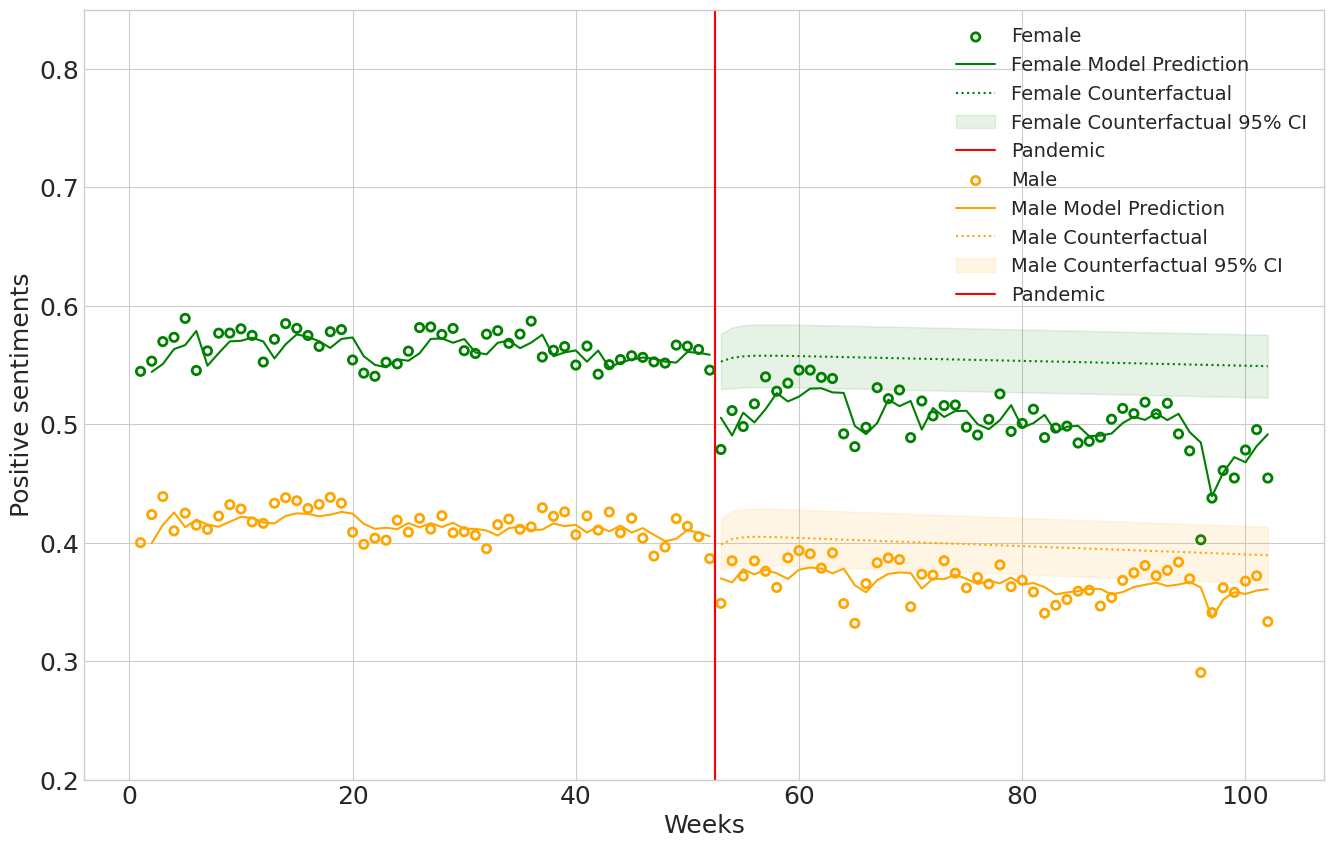

In [42]:
#import matplotlib.pyplot as plt
#from statsmodels.tsa.arima_model import ARIMA

# Define a function to generate the ARIMA plots
def generate_arima_plot(ax, df, arima_results, color, label):
    start = 52
    end = 102

    # get the model predictions for the whole time period (start till end)
    predictions = arima_results.get_prediction(0, end-1)

    # get the counterfactual ARIMA by fitting a model only for the first time period (before the pandemic)
    arima_cf = ARIMA(df["Y"][:start], df["T"][:start], order=(1,1,1)).fit()

    # model predictions means
    y_pred = predictions.predicted_mean

    # counterfactual mean and 95% confidence interval
    y_cf = arima_cf.get_forecast(50, exog=df["T"][start:]).summary_frame(alpha=0.05)

    # plot weekly sentiment data
    ax.scatter(df["T"], df["Y"], facecolors='none', edgecolors=color, label=label, linewidths=2)

    # plot model mean sentiment prediction
    ax.plot(df["T"][1:start], y_pred[1:start], color=color, linestyle='-', label=f"{label} Model Prediction")
    ax.plot(df["T"][start:], y_pred[start:], color=color, linestyle='-')

    # plot counterfactual mean sentiment with 95% confidence interval
    ax.plot(df["T"][start:], y_cf["mean"], color=color, linestyle='dotted', label=f"{label} Counterfactual")
    ax.fill_between(df["T"][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color=color, alpha=0.1, label=f"{label} Counterfactual 95% CI")

    # plot line marking the week of the official start of the pandemic (WHO)
    ax.axvline(x=52.5, color='r', label='Pandemic')

    ax.set_ylim([0.2, 0.85])
    ax.set_xlabel("Weeks", fontsize=18)
    ax.set_ylabel("Positive sentiments", fontsize=18)
    ax.legend(loc='best', fontsize=14)

    # Update tick label font size
    ax.tick_params(axis='both', which='major', labelsize=18)


# Create a single plot
fig, ax = plt.subplots(figsize=(16, 10))

# Generate the first plot (female data) in green
generate_arima_plot(ax, df_f, arima_results_f, color='green', label='Female')

# Generate the second plot (male data) in orange
generate_arima_plot(ax, df_m, arima_results_m, color='orange', label='Male')

# Show the combined plot
plt.show()



### H2: NEGATIVE - ARIMA female

In [43]:
# define df
Y = h2_df_female["neg_sent"]
T = h2_df_female["week_T"]
D = h2_df_female["pandemic_D"]
df_f = pd.DataFrame({"Y": Y, "T": T, "D": D})

In [44]:
# fit the ARIMA model automatically 
model = pm.auto_arima(df_f["Y"], seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-596.992, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-587.706, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-589.798, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-592.048, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-589.308, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-598.249, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-599.649, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-599.356, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-603.074, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-601.153, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-590.932, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-598.206, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.942 seconds


In [46]:
# specify ARIMA model using the proposed parameters
arima_results_f = ARIMA(df_f["Y"], df_f[["T", "D"]], order=(1,1,1)).fit()
print(arima_results_f.summary(alpha=0.025))

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  102
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 307.293
Date:                Tue, 22 Oct 2024   AIC                           -604.586
Time:                        14:21:13   BIC                           -591.510
Sample:                             0   HQIC                          -599.292
                                - 102                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|     [0.0125     0.9875]
------------------------------------------------------------------------------
T              0.0006      0.000      2.266      0.023    6.55e-06       0.001
D              0.0168      0.010      1.745      0.081      -0.005       0.038
ar.L1          0.5454      0.133      4.113      0.0

The descriptive statistic says that the official start of the pandemic had a positive effect on the negative sentiments. D (dummy coded variable indicating the start of the pandemic) has a **coeficient of 0.0168** (not significant). But some model assumptions are violated (Homoscedasticity (Prob(H)<0.05), normally distributed residuals (Prob(JB)<0.05)). Because of that the inference statistic is not reliable.

Let's use Bootstrapping method to deal our data:

In [47]:
# Define the number of bootstrap samples
n_bootstrap_samples = 1000
coefficient_D_estimates = []

# Set the random seed for reproducibility
np.random.seed(42)

# Define the block size for block bootstrapping
block_size = 3  # how many segments of data are resampled together (I need a quite small block size to capture short-term variation (effect of the start of the pandemic))

# Perform block bootstrapping
for _ in range(n_bootstrap_samples):
    # Generate a bootstrap sample of 'Y' and 'D' using block bootstrapping
    bootstrap_indices = np.random.randint(1, len(df_f) - block_size, len(df_f) // block_size)
    bootstrap_indices = np.repeat(bootstrap_indices, block_size) + np.tile(np.arange(block_size), len(bootstrap_indices))
    bootstrap_sample = df_f.iloc[bootstrap_indices]

    # Fit ARIMA model to the bootstrap sample
    bootstrap_model = ARIMA(bootstrap_sample["Y"], bootstrap_sample[["T", "D"]], order=(1, 1, 1)).fit()

    # Store the estimated coefficient for 'D'
    coefficient_D_estimates.append(bootstrap_model.params["D"])

# Calculate standard errors and confidence intervals for the coefficient of 'D'
coefficient_D_estimates = np.array(coefficient_D_estimates)
coefficient_D_std_error = coefficient_D_estimates.std()
coefficient_D_ci_lower = np.percentile(coefficient_D_estimates, 1.25)
coefficient_D_ci_upper = np.percentile(coefficient_D_estimates, 98.75)

# Print the results
print("Bootstrap Standard Error for Coefficient of 'D':", coefficient_D_std_error)
print("Bootstrap 97.5% Confidence Interval for Coefficient of 'D':")
print("Lower Bound:", coefficient_D_ci_lower)
print("Upper Bound:", coefficient_D_ci_upper)

Bootstrap Standard Error for Coefficient of 'D': 0.009447681130623671
Bootstrap 97.5% Confidence Interval for Coefficient of 'D':
Lower Bound: -0.011323760873610813
Upper Bound: 0.03006159393485747


    Bootstrap Standard Error for Coefficient of 'D': 0.009447681130623671
    Bootstrap 97.5% Confidence Interval for Coefficient of 'D':
    Lower Bound: -0.011323760873610813
    Upper Bound: 0.03006159393485747

Robust estimation of the D coefficient via bootstrapping says that the true value of the D coef lies with 97.5% probability within the range of the **CI [-0.011; 0.030]**. 
**The ARIMA model suggested a value inside of this interval: 0.0168.**
The fact that the ARIMA coefficient falls within the bootstrapped confidence interval underscores the roustness of the estimated coef, indicating that it remains stable under different resampling scenarios. However, the CI is quite wide (and the SE quite high), suggesting that there is a fair amount of uncertainty in the coef estimate. The CI also includes zero, meaning that there is a possibility that the coef doesn't have a meaningful effect (not statistically significantly different from zero/no strong evidence for a significant effect (as the ARIMA model already suggested)). It is possible that the interval is wide simply due to sample variation. 
To interpret the results, we should focus on the point estimate of the coef within the CI because it represents the best estimate of the effect's magnitude. 

Let's plot this:

Text(0, 0.5, 'Negative sentiments')

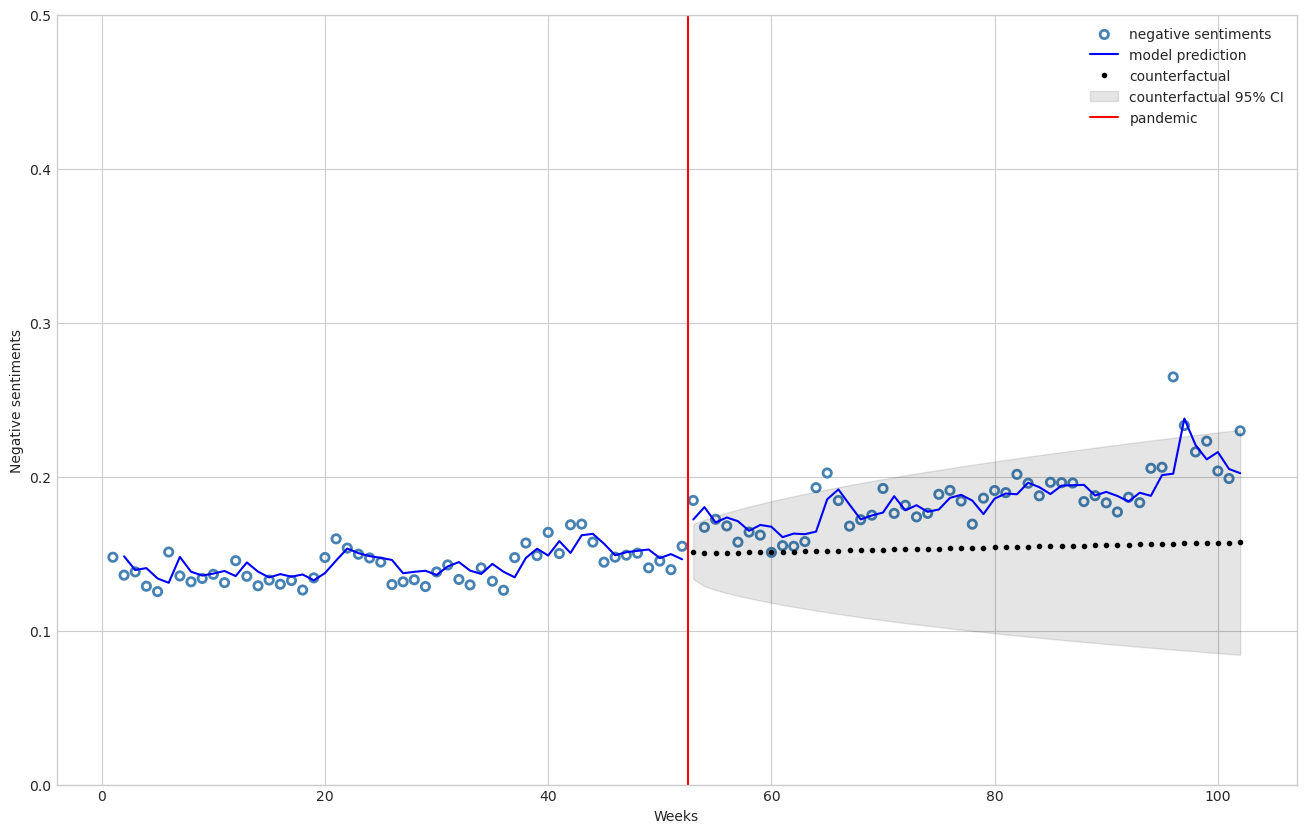

In [48]:
start = 52
end = 102

# get the model predictions for the whole time period (start till end)
predictions = arima_results_f.get_prediction(0, end-1)
summary = predictions.summary_frame(alpha=0.025)

# get the counterfactual ARIMA by fitting a model only for the first time period (before the pandemic)
arima_cf = ARIMA(df_f["Y"][:start], df_f["T"][:start], order=(1,1,1)).fit()

# model predictions means
y_pred = predictions.predicted_mean

# counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(50, exog=df_f["T"][start:]).summary_frame(alpha=0.05)

# plot section
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# plot weekly sentiment data
ax.scatter(df_f["T"], df_f["Y"], facecolors='none', edgecolors='steelblue', label="negative sentiments", linewidths=2)

# plot model mean sentiment prediction
ax.plot(df_f["T"][1:start], y_pred[1:start], 'b-', label="model prediction")
ax.plot(df_f["T"][start:], y_pred[start:], 'b-')

# plot counterfactual mean sentiment with 95% confidence interval
ax.plot(df_f["T"][start:], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(df_f["T"][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="counterfactual 95% CI")


# plot line marking the week of the official start of the pandemic (WHO)
ax.axvline(x = 52.5, color = 'r', label = 'pandemic')

ax.legend(loc='best')
plt.ylim([0, 0.5])
plt.xlabel("Weeks")
plt.ylabel("Negative sentiments")

### H2: NEGATIVE - ARIMA male

In [49]:
# define df
Y = h2_df_male["neg_sent"]
T = h2_df_male["week_T"]
D = h2_df_male["pandemic_D"]
df_m = pd.DataFrame({"Y": Y, "T": T, "D": D})

In [50]:
# fit the ARIMA model automatically 
model = pm.auto_arima(df_m["Y"], seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-563.678, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-565.392, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-575.879, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-565.395, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-584.990, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-587.929, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-586.837, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-589.267, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-586.870, Time=0.20 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-585.474, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-581.414, Time=0.08 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 1.252 seconds


In [51]:
# specify ARIMA model using the proposed parameters
arima_results_m = ARIMA(df_m["Y"], df_m[["T", "D"]], order=(0,1,2)).fit()
print(arima_results_m.summary(alpha=0.025))

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  102
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 302.953
Date:                Tue, 22 Oct 2024   AIC                           -595.906
Time:                        14:25:36   BIC                           -582.831
Sample:                             0   HQIC                          -590.613
                                - 102                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|     [0.0125     0.9875]
------------------------------------------------------------------------------
T              0.0005      0.000      3.880      0.000       0.000       0.001
D              0.0193      0.009      2.149      0.032      -0.001       0.039
ma.L1         -0.6142      0.298     -2.064      0.0

The descriptive statistic says that the official start of the pandemic had a positive effect on the negative sentiments. D (dummy coded variable indicating the start of the pandemic) has a **coeficient of 0.0193**. But some model assumptions are violated (Homoscedasticity (Prob(H)<0.05), normally distributed residuals (Prob(JB)<0.05)). Because of that the inference statistic is not reliable.

Let's use Bootstrapping method to deal our data:

In [52]:
# Define the number of bootstrap samples
n_bootstrap_samples = 1000
coefficient_D_estimates = []

# Set the random seed for reproducibility
np.random.seed(42)

# Define the block size for block bootstrapping
block_size = 3  # how many segments of data are resampled together (I need a quite small block size to capture short-term variation (effect of the start of the pandemic))

# Perform block bootstrapping
for _ in range(n_bootstrap_samples):
    # Generate a bootstrap sample of 'Y' and 'D' using block bootstrapping
    bootstrap_indices = np.random.randint(1, len(df_m) - block_size, len(df_m) // block_size)
    bootstrap_indices = np.repeat(bootstrap_indices, block_size) + np.tile(np.arange(block_size), len(bootstrap_indices))
    bootstrap_sample = df_m.iloc[bootstrap_indices]

    # Fit ARIMA model to the bootstrap sample
    bootstrap_model = ARIMA(bootstrap_sample["Y"], bootstrap_sample[["T", "D"]], order=(0, 1, 2)).fit()

    # Store the estimated coefficient for 'D'
    coefficient_D_estimates.append(bootstrap_model.params["D"])

# Calculate standard errors and confidence intervals for the coefficient of 'D'
coefficient_D_estimates = np.array(coefficient_D_estimates)
coefficient_D_std_error = coefficient_D_estimates.std()
coefficient_D_ci_lower = np.percentile(coefficient_D_estimates, 1.25)
coefficient_D_ci_upper = np.percentile(coefficient_D_estimates, 98.75)

# Print the results
print("Bootstrap Standard Error for Coefficient of 'D':", coefficient_D_std_error)
print("Bootstrap 97.5% Confidence Interval for Coefficient of 'D':")
print("Lower Bound:", coefficient_D_ci_lower)
print("Upper Bound:", coefficient_D_ci_upper)

Bootstrap Standard Error for Coefficient of 'D': 0.006680847640723335
Bootstrap 97.5% Confidence Interval for Coefficient of 'D':
Lower Bound: 0.0030718890150293107
Upper Bound: 0.034798079684226026


    Bootstrap Standard Error for Coefficient of 'D': 0.006680847640723335
    Bootstrap 97.5% Confidence Interval for Coefficient of 'D':
    Lower Bound: 0.0030718890150293107
    Upper Bound: 0.034798079684226026

Robust estimation of the D coefficient via bootstrapping says that the true value of the D coef lies with 97.5% probability within the range of the **CI [0.0031; 0.0345]**. 
**The ARIMA model suggested a value inside of this interval: 0.0193.**
The fact that the ARIMA coefficient falls within the bootstrapped confidence interval underscores the roustness of the estimated coef, indicating that it remains stable under different resampling scenarios. However, the CI is quite wide (and the SE quite high), suggesting that there is a fair amount of uncertainty in the coef estimate. The CI also includes zero, meaning that there is a possibility that the coef doesn't have a meaningful effect (not statistically significantly different from zero/no strong evidence for a significant effect). It is also possible that the interval is wide simply due to sample variation. 
To interpret the results, we should focus on the point estimate of the coef within the CI because it represents the best estimate of the effect's magnitude. 

Let's plot this:

Text(0, 0.5, 'Negative sentiments')

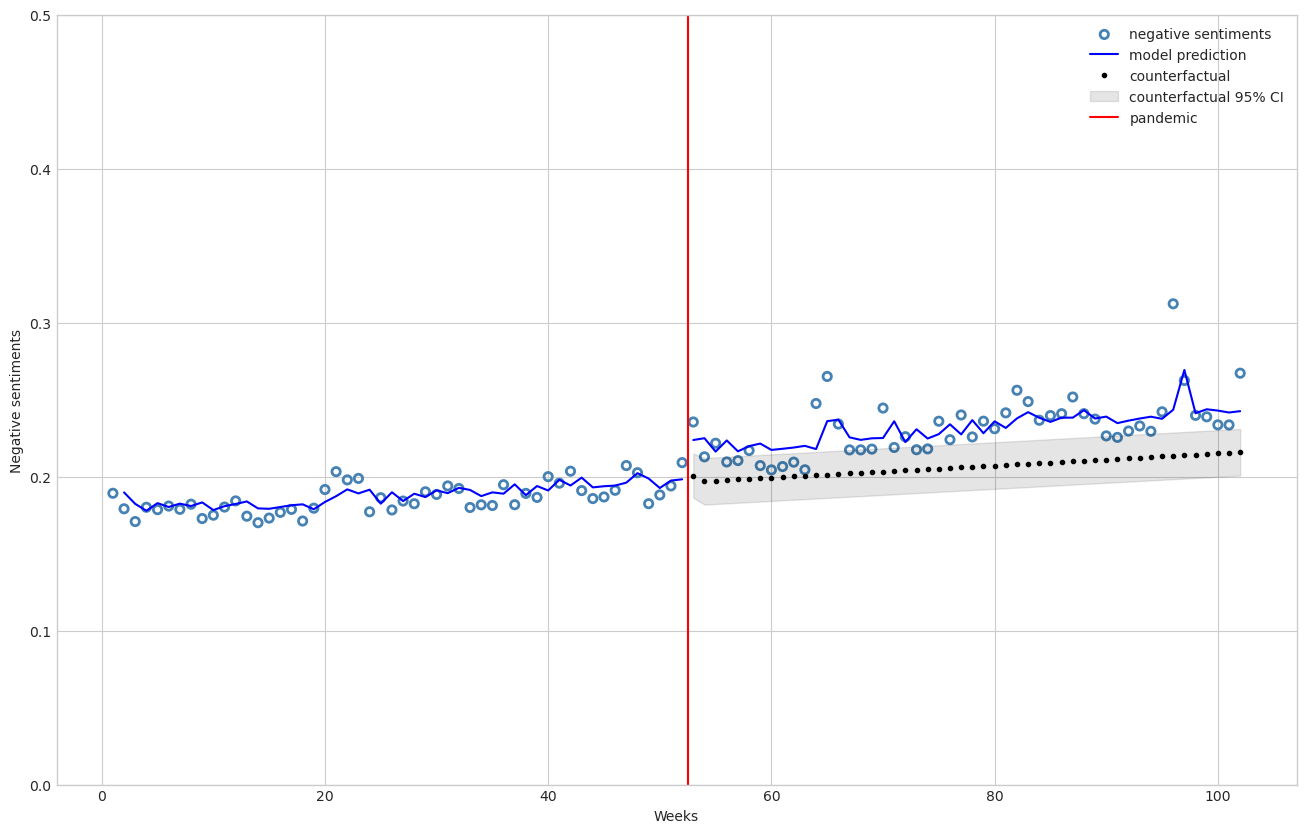

In [53]:
start = 52
end = 102

# get the model predictions for the whole time period (start till end)
predictions = arima_results_m.get_prediction(0, end-1)
summary = predictions.summary_frame(alpha=0.025)

# get the counterfactual ARIMA by fitting a model only for the first time period (before the pandemic)
arima_cf = ARIMA(df_m["Y"][:start], df_m["T"][:start], order=(0,1,2)).fit()

# model predictions means
y_pred = predictions.predicted_mean

# counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(50, exog=df_m["T"][start:]).summary_frame(alpha=0.05)

# plot section
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# plot weekly sentiment data
ax.scatter(df_m["T"], df_m["Y"], facecolors='none', edgecolors='steelblue', label="negative sentiments", linewidths=2)

# plot model mean sentiment prediction
ax.plot(df_m["T"][1:start], y_pred[1:start], 'b-', label="model prediction")
ax.plot(df_m["T"][start:], y_pred[start:], 'b-')

# plot counterfactual mean sentiment with 95% confidence interval
ax.plot(df_m["T"][start:], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(df_m["T"][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="counterfactual 95% CI")


# plot line marking the week of the official start of the pandemic (WHO)
ax.axvline(x = 52.5, color = 'r', label = 'pandemic')

ax.legend(loc='best')
plt.ylim([0, 0.5])
plt.xlabel("Weeks")
plt.ylabel("Negative sentiments")

### H2: NEGATIVE - coeff comparison

We are interested in whether the pandemic had a stronger effect on females than on males.
To answer this question, let's ckeck whether the pandemic coefficents (D) differ significantly between females and males using the Wald test.

In [54]:
# coefficient estimates (ARIMA) and standard errors (estimated via bootstrapping) from the two models
beta_f = 0.0168
se_f = 0.0095
beta_m = 0.0193
se_m = 0.0067

# calculate the Wald test statistic
wald_statistic = ((beta_f - beta_m) ** 2) / (se_f ** 2 + se_m ** 2)

# calculate the p-value
p_val = 1 - stats.chi2.cdf(wald_statistic, df=1) # 1 degree of freedom

# print the results
print(f"Wald Test Statistic: {wald_statistic}")
print(f"P-value: {p_val}")

# check if the coefficients are significantly different
if p_val < 0.05:
    print("Reject the null hypothesis: Coefficients are significantly different.")
else:
    print("Fail to reject the null hypothesis: Coefficients are not significantly different.")

Wald Test Statistic: 0.046248335059937924
P-value: 0.829725014157376
Fail to reject the null hypothesis: Coefficients are not significantly different.


The pandemic's effect on the positive sentiment doesn't differ significantly between males and females. This is in line with the overlapping CIs from the bootstrapping estimation.

But it should be observable on a descriptive level:

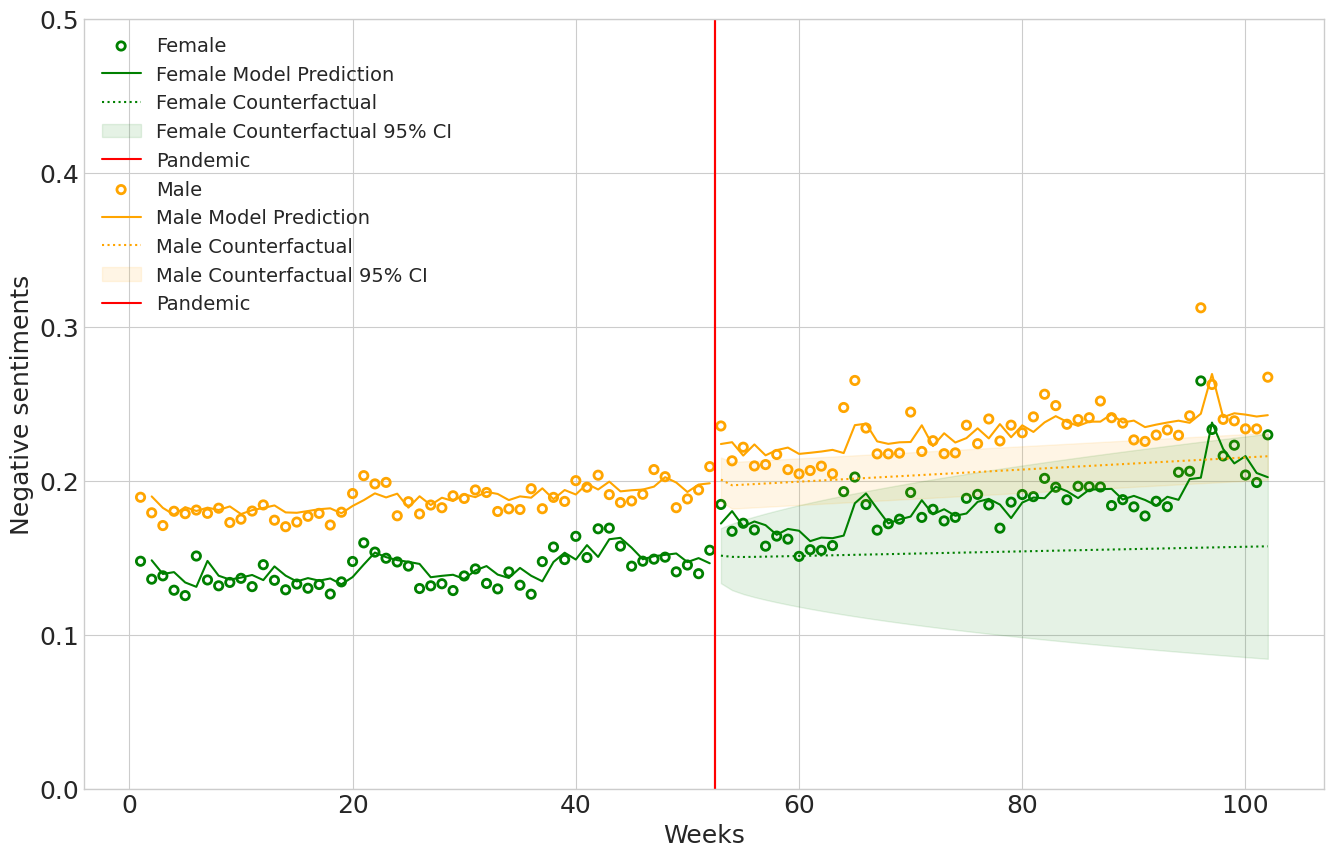

In [55]:
#import matplotlib.pyplot as plt
#from statsmodels.tsa.arima_model import ARIMA

# Define a function to generate the ARIMA plots
def generate_arima_plot(ax, df, arima_order, color, label):
    start = 52
    end = 102

    # Fit ARIMA model
    arima_model = ARIMA(df["Y"], df[["T", "D"]], order=arima_order).fit()

    # Get model predictions for the whole time period (start till end)
    predictions = arima_model.get_prediction(0, end-1)

    # Get the counterfactual ARIMA by fitting a model only for the first time period (before the pandemic)
    arima_cf = ARIMA(df["Y"][:start], df["T"][:start], order=arima_order).fit()

    # Model predictions means
    y_pred = predictions.predicted_mean

    # Counterfactual mean and 95% confidence interval
    y_cf = arima_cf.get_forecast(50, exog=df["T"][start:]).summary_frame(alpha=0.05)

    # Plot weekly sentiment data
    ax.scatter(df["T"], df["Y"], facecolors='none', edgecolors=color, label=label, linewidths=2)

    # Plot model mean sentiment prediction
    ax.plot(df["T"][1:start], y_pred[1:start], color=color, linestyle='-', label=f"{label} Model Prediction")
    ax.plot(df["T"][start:], y_pred[start:], color=color, linestyle='-')

    # Plot counterfactual mean sentiment with 95% confidence interval
    ax.plot(df["T"][start:], y_cf["mean"], color=color, linestyle='dotted', label=f"{label} Counterfactual")
    ax.fill_between(df["T"][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color=color, alpha=0.1, label=f"{label} Counterfactual 95% CI")

    # Plot line marking the week of the official start of the pandemic (WHO)
    ax.axvline(x=52.5, color='r', label='Pandemic')

    ax.set_ylim([0, 0.5])
    ax.set_xlabel("Weeks", fontsize=18)
    ax.set_ylabel("Negative sentiments", fontsize=18)
    ax.legend(loc='best', fontsize=14)

    # Update tick label font size
    ax.tick_params(axis='both', which='major', labelsize=18)

# Create a single plot
fig, ax = plt.subplots(figsize=(16, 10))

# Specify ARIMA orders for male and female datasets
arima_order_female = (1, 1, 1)
arima_order_male = (0, 1, 2)

# Generate the first plot (female data) in green with the specified ARIMA order
generate_arima_plot(ax, df_f, arima_order_female, color='green', label='Female')

# Generate the second plot (male data) in orange with the specified ARIMA order
generate_arima_plot(ax, df_m, arima_order_male, color='orange', label='Male')

# Show the combined plot
plt.show()

In [56]:
import psutil
import platform
import pkg_resources

def session_info():
    info = {
        'Python': sys.version,
        'Platform': platform.platform(),
        'Processor': platform.processor(),
        'Memory': psutil.virtual_memory(),
        'Packages': '\n'.join([f"{dist.project_name}=={dist.version}" for dist in pkg_resources.working_set])
    }
    for key, value in info.items():
        print(f"{key}: {value}")

session_info()

Python: 3.11.7 (main, Dec 15 2023, 18:12:31) [GCC 11.2.0]
Platform: Linux-5.15.0-107-generic-x86_64-with-glibc2.35
Processor: x86_64
Memory: svmem(total=269929680896, available=262455975936, percent=2.8, used=5060960256, free=167570518016, active=87677530112, inactive=12342022144, buffers=1652936704, cached=95645265920, shared=13651968, slab=1837375488)
Packages: Automat==20.2.0
Babel==2.11.0
Bottleneck==1.3.7
Brotli==1.0.9
Cython==3.0.11
Flask==2.2.5
GitPython==3.1.37
HeapDict==1.0.1
Jinja2==3.1.3
Markdown==3.4.1
MarkupSafe==2.1.3
Protego==0.1.16
PyDispatcher==2.0.5
PyJWT==2.4.0
PyQt5==5.15.10
PyQt5-sip==12.13.0
PyQtWebEngine==5.15.6
PySocks==1.7.1
PyYAML==6.0.1
Pygments==2.15.1
QDarkStyle==3.0.2
QtAwesome==1.2.2
QtPy==2.4.1
Rtree==1.0.1
SQLAlchemy==2.0.25
Scrapy==2.8.0
SecretStorage==3.3.1
Send2Trash==1.8.2
Sphinx==5.0.2
Unidecode==1.2.0
Werkzeug==2.2.3
aiobotocore==2.7.0
aiohttp==3.9.3
aioitertools==0.7.1
aiosignal==1.2.0
alabaster==0.7.12
altair==5.0.1
anaconda-anon-usage==0.4.3
an